![img](https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

На этом занятии помимо базового функционала `pytorch` будет использоваться библиотека для зрения **`torchvision`**.

# Pytorch как конструктор

## Работа с датасетами

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Кастомный пример — датасет, загружающий изображения на основе путей и классов из текстового файла:

In [3]:
from torch.utils.data import Dataset
# default_loader - стандартная функция для загрузки изображений, использует accimage или PIL
from torchvision.datasets.folder import default_loader

class TxtList(Dataset):
    def __init__(self, path, transform=None, loader=default_loader):
        with open(path) as fin:
            self.imgs = [s.strip().split() for s in fin.readlines()]

        print(f'=> Found {len(self.imgs)} entries in {path}')

        self.classes = sorted(set([_[1] for _ in self.imgs]))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        path, target = self.imgs[index]
        target = self.class_to_idx[target]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
!echo '/tmp/1.jpg\tcat' > /tmp/dataset.tsv
!echo '/tmp/2.jpg\tcat' >> /tmp/dataset.tsv
!echo '/tmp/3.jpg\tdog' >> /tmp/dataset.tsv
!echo '/tmp/4.jpg\tcat' >> /tmp/dataset.tsv

In [5]:
catdog = TxtList('/tmp/dataset.tsv')

=> Found 4 entries in /tmp/dataset.tsv


In [6]:
catdog.classes

['cat', 'dog']

In [7]:
catdog.imgs

[['/tmp/1.jpg', 'cat'],
 ['/tmp/2.jpg', 'cat'],
 ['/tmp/3.jpg', 'dog'],
 ['/tmp/4.jpg', 'cat']]

In [8]:
len(catdog)

4

In [9]:
# FileNotFoundError
catdog[0]

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/1.jpg'

`torchvision` также содержит и другие готовые классы для стандартных датасетов: 
http://pytorch.org/docs/master/torchvision/datasets.html.

Некоторые из них можно сразу и загрузить — например, **MNIST**:

In [10]:
![ -d '/tmp/mnist/' ] && rm -r '/tmp/mnist/'

In [11]:
from torchvision.datasets import MNIST

%time mnist = MNIST('/tmp/mnist/', train=True, download=True)

Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw


Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw


Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw


Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw
Processing...


/home/serega/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:457: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
CPU times: user 1.85 s, sys: 476 ms, total: 2.33 s
Wall time: 13.8 s


In [12]:
len(mnist)

60000

In [13]:
image, target = mnist[0]
print(target)

5


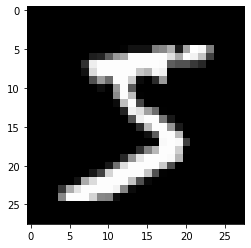

In [14]:
plt.imshow(np.array(image), 'gray')
plt.show()

## <font color='#cc6666'>Внимание, задача!</font>

Релизуйте ниже датасет **`UrlList`**, конструктор которого на вход принимает список ссылок на изображения.

In [ ]:
class UrlList(Dataset):
    pass

Покажите его работу на примере:

In [ ]:
pass

## Преобразования данных

Конструктор примера, приведенного выше, также как и стандартного `ImageFolder`, принимают параметр `transform` (и `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований:

In [15]:
from torchvision import transforms

Например, `transforms.ToTensor()` преобразует `PIL`-изображение типа uint8 с доменом [0, 256) в тензор с доменом [0, 1].

In [16]:
from torchvision import transforms
to_tensor = transforms.ToTensor()

In [17]:
pil_image = mnist[0][0]
th_image = to_tensor(pil_image)
th_image.shape, th_image.min(), th_image.max()

(torch.Size([1, 28, 28]), tensor(0.), tensor(1.))

А для того, чтобы нормализовывать изображения из ImageNet'а по стандартной схеме, можно объявить

In [18]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Для объединения нескольких преобразваний в одно есть `Compose`:

In [19]:
from torchvision import transforms
crop_and_tensorize = transforms.Compose([
    transforms.CenterCrop(16),
    transforms.ToTensor(),
])

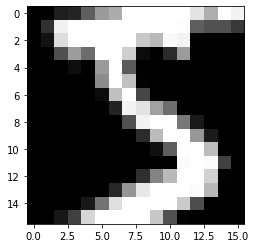

In [20]:
plt.imshow(crop_and_tensorize(pil_image)[0].numpy(), 'gray')
plt.show()

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в http://pytorch.org/docs/master/torchvision/transforms.html.

## <font color='#cc6666'>Внимание, задача!</font>

Реализуйте класс-трансформер, осуществляющий с подаваемым на вход изображением случайное преобразование из группы диэдра $D_4$.

In [15]:
class RandomD4(object):
    def __call__(self, img):
        pass

Покажите его работу на примере из MNIST:

In [16]:
pass

## Загрузчики данных

Основная магия, для которой и нужны датасеты в приведенном выше виде, это загрузчики:

In [21]:
from torch.utils.data import DataLoader

Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

При этом батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах!

Рассмотрим их на примере с MNIST, при этом добавим к нему трансформер, т.к. лоадеры работают с тензорами или скалярами, но не `PIL.Image`.

In [22]:
transformed_mnist = MNIST('/tmp/mnist/', train=True, transform=transforms.ToTensor())

In [23]:
mnist_loader = DataLoader(transformed_mnist, batch_size=16, shuffle=True, num_workers=4)  # замечение про shuffle

Стандартные параметры приведены выше. При добавлении **`pin_memory=True`** батчи еще и сразу раскладываются по видеокартам.

Посмотрим на работу в деле:

In [24]:
for images, targets in tqdm(mnist_loader):
    pass

100%|██████████| 3750/3750 [00:06<00:00, 621.95it/s]


На выходе из лоадера получаем батчи:

In [25]:
images.shape

torch.Size([16, 1, 28, 28])

In [26]:
targets.shape

torch.Size([16])

Количество батчей заранее известно (чему был рад `tqdm`):

In [28]:
len(mnist_loader)

3750

Пример данных (при каждом повторении прохода по мнисту пример будет случайным):

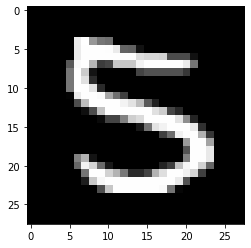

In [32]:
plt.imshow(images[0][0].numpy(), 'gray')
plt.show()

In [34]:
print(targets[0])

tensor(5)


## Создание моделей

Для создания моделей наследуемся от `torch.nn.Module`, `torch.nn` также содержит стандартные "кирпичики" моделей.

Функциональные версии кирпичей скрыты в `torch.nn.functional`.

In [35]:
import torch.nn as nn
import torch.nn.functional as F

Для макспулинга, активаций, апсемплинга и некоторых других операций есть как "модульные", так и "функциональные" версии:
* `nn.MaxPool2d` / `F.max_pool2d`
* `nn.ReLU` / `F.relu`
* `nn.Upsample(mode='bilinar')` / `F.upsample(mode='bilinar')` — **deprecated** в пользу `F.interpolate`

При использовании модульных версий слоев во время создания простой модели можно обходиться `nn.Sequential` для их "склейки":

In [27]:
layers = [
    nn.Conv2d(3, 64, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU()
]
unet_down1 = nn.Sequential(*layers)
print(unet_down1)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
)


## Обучение моделей

Для обучения моделей необходимо определить функцию потерь, их примеры содержатся все в том же модуле `torch.nn`:

```python
output = model(torch.cat(x, 1))
target = torch.arange(1, 1001)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)
```

Веса обновлять можно как вручную (или воспользоваться реализованным ранее оптимизатором):

```python
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)
```

Так и пользоваться стандартным оптимизатором из модуля `torch.optim`:
```python
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)
```

Для зануления градиентов теперь можно обращаться к оптимизатору:
```python
optimizer.zero_grad()
```

Инференс, подсчет ошибки и бэкпроп делаем как раньше:
```python
output = net(x)
loss = criterion(output, target)
loss.backward()
```

А для обновления весов используем оптимизатор:
```python
optimizer.step()
```

Для работы с шагом обучения в **`optim`** есть подмодуль **`torch.optim.lr_scheduler`**:
```python
from torch.optim import lr_scheduler
```

Например, обучение ResNet на ImageNet по стандартной схеме будет работать примерно так:
```python
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
for epoch in range(100):
     scheduler.step()  # == scheduler.step(epoch)
     # train(...)
     # validate(...)
```

# Pytorch в бою

## Создание модели сегментации на примере U-Net

![img](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [36]:
import torch
from torch import nn

Часто используемые свертки:

In [37]:
def conv3x3(in_channels, out_channels, dilation=1):
    return nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation)

Один **блок кодировщика** состоит из двух последовательных сверток, активаций и опционального батчнорма:

In [38]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()

        self.batch_norm = batch_norm

        self.conv1 = conv3x3(in_channels, out_channels)
        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = conv3x3(out_channels, out_channels)
        if self.batch_norm:
            self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = self.relu2(x)
        return x

In [39]:
block = EncoderBlock(3, 64)
block

EncoderBlock(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
)

In [40]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

torch.Size([4, 64, 128, 128])


Альтернативное объявление:

In [41]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()

        self.block = nn.Sequential()
        self.block.add_module('conv1', conv3x3(in_channels, out_channels))
        if batch_norm:
            self.block.add_module('bn1', nn.BatchNorm2d(out_channels))
        self.block.add_module('relu1', nn.ReLU())
        self.block.add_module('conv2', conv3x3(out_channels, out_channels))
        if batch_norm:
            self.block.add_module('bn2', nn.BatchNorm2d(out_channels))
        self.block.add_module('relu2', nn.ReLU())

    def forward(self, x):
        return self.block(x)

In [42]:
block = EncoderBlock(3, 64)
block

EncoderBlock(
  (block): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
)

In [43]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

torch.Size([4, 64, 128, 128])


И "функциональная версия":

In [44]:
def encoder_block(in_channels, out_channels, batch_norm=False):
    block = nn.Sequential()
    block.add_module('conv1', conv3x3(in_channels, out_channels))
    if batch_norm:
        block.add_module('bn1', nn.BatchNorm2d(out_channels))
    block.add_module('relu1', nn.ReLU())
    block.add_module('conv2', conv3x3(out_channels, out_channels))
    if batch_norm:
        block.add_module('bn2', nn.BatchNorm2d(out_channels))
    block.add_module('relu2', nn.ReLU())
    return block

In [45]:
block = encoder_block(3, 64)
block

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
)

In [46]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

torch.Size([4, 64, 128, 128])


Кодировщик в целом состоит из рассмотренных блоков.

Его конструкция определяется входными каналами, количеством фильтров в первом блоке и количеством блоков.

Помним также, что для работы сети нам нужно запоминать промежуточные активации.

In [47]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_filters, num_blocks):
        super().__init__()

        self.num_blocks = num_blocks
        for i in range(num_blocks):
            in_channels = in_channels if not i else num_filters * 2 ** (i - 1)
            out_channels = num_filters * 2**i
            self.add_module(f'block{i + 1}', encoder_block(in_channels, out_channels))
            if i != num_blocks - 1:
                self.add_module(f'pool{i + 1}', nn.MaxPool2d(2, 2))

    def forward(self, x):
        acts = []
        for i in range(self.num_blocks):
            x = self.__getattr__(f'block{i + 1}')(x)
            acts.append(x)
            if i != self.num_blocks - 1:
                x = self.__getattr__(f'pool{i + 1}')(x)
        return acts

Здесь как раз помогает подход к построению через с **`add_module`**, т.к. их количество переменно.

In [49]:
encoder = Encoder(in_channels=3, num_filters=8, num_blocks=4)
encoder

Encoder(
  (block1): Sequential(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): Sequential(
    (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3): Sequential(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block4): Sequential(
    (conv1): Conv2d(32, 64, kernel_s

In [50]:
x = torch.zeros(4, 3, 512, 512)

[_.shape for _ in encoder(x)]

[torch.Size([4, 8, 512, 512]),
 torch.Size([4, 16, 256, 256]),
 torch.Size([4, 32, 128, 128]),
 torch.Size([4, 64, 64, 64])]

Блок декодировщика состоит из апскейлинга входа "снизу", объединения двух входов и сверток как в кодировщике:

In [55]:
class DecoderBlock(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.uppool = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upconv = conv3x3(out_channels * 2, out_channels)
        self.conv1 = conv3x3(out_channels * 2, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)

    def forward(self, down, left):
        x = self.uppool(down)
        x = self.upconv(x)
        x = torch.cat([left, x], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [56]:
block = DecoderBlock(8)

In [57]:
y = encoder(x)

In [58]:
y[1].shape, y[0].shape

(torch.Size([4, 16, 256, 256]), torch.Size([4, 8, 512, 512]))

In [59]:
block(y[1], y[0]).shape

/home/serega/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([4, 8, 512, 512])

Декодировщик собираем из таких блоков:

In [47]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [48]:
decoder = Decoder(8, 3)

In [49]:
x.shape

torch.Size([4, 3, 512, 512])

In [50]:
[_.shape for _ in encoder(x)]

[torch.Size([4, 8, 512, 512]),
 torch.Size([4, 16, 256, 256]),
 torch.Size([4, 32, 128, 128]),
 torch.Size([4, 64, 64, 64])]

In [51]:
decoder(encoder(x)).shape

/home/nizhib/.anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/nizhib/.anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([4, 8, 512, 512])

U-Net состоит из такого кодировщика и декодировщика, а также финального слоя классификации:

In [52]:
class UNet(nn.Module):
    def __init__(self, num_classes, in_channels=3, num_filters=64, num_blocks=4):
        super().__init__()

        print(f'=> Building {num_blocks}-blocks {num_filters}-filter U-Net')

        self.encoder = Encoder(in_channels, num_filters, num_blocks)
        self.decoder = Decoder(num_filters, num_blocks - 1)
        self.final = nn.Conv2d(num_filters, num_classes, 1)

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

"Интеграционное тестирование" (pytorch 0.3):

In [53]:
from torch.autograd import Variable

model = UNet(num_classes=1)
if torch.cuda.is_available():
    model.cuda()

images = Variable(torch.randn(4, 3, 416, 416), volatile=True)
if torch.cuda.is_available():
    images = images.cuda()

model.forward(images).shape

=> Building 4-blocks 64-filter U-Net


/home/nizhib/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/home/nizhib/.anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/nizhib/.anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([4, 1, 416, 416])

То же для **pytorch 0.4+**:

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

images = torch.randn(4, 3, 416, 416).to(device)

model.forward(images).shape

/home/nizhib/.anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/nizhib/.anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([4, 1, 416, 416])

На выходе получаем бинарную маску из линейных активаций.

Для обучения такой модели используются функции потерь с **WithLogits** в названии.

В вероятности их можно превращать с помощью `torch.sigmoid` (**0.4.1+**) (`torch.nn.functional.sigmoid` ранее)

## Использование готового кодировщика

Структура блоков кодировщика рассмотренной только что сети сильно походит на таковую в сетях VGG:

![img](https://www.pyimagesearch.com/wp-content/uploads/2017/03/imagenet_vgg16.png)

Посмотрим на неё же из недр `torchvision`:

In [55]:
from torchvision.models import vgg13

VGG13 - версия сети с 2 сверткаим на каждый блок:

In [56]:
model = vgg13()

In [57]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU(inplace)
    (17): Conv2d

Классификатор нам не нужен, интересуют только признаки.

Они в свою очередь делятся на блоки conv-relu-conv-relu + maxpooling.

Реализуем кодировщик на основе вычленения нужных блоков:

In [58]:
class VGG13Encoder(nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()

        backbone = vgg13(pretrained=pretrained).features

        self.num_blocks = num_blocks
        for i in range(self.num_blocks):
            block = nn.Sequential(*[backbone[j] for j in range(i * 5, i * 5 + 4)])
            self.add_module(f'block{i + 1}', block)
            if i != num_blocks - 1:
                self.add_module(f'pool{i + 1}', nn.MaxPool2d(2, 2))

    def forward(self, x):
        acts = []
        for i in range(self.num_blocks):
            x = self.__getattr__(f'block{i + 1}')(x)
            acts.append(x)
            if i != self.num_blocks - 1:
                x = self.__getattr__(f'pool{i + 1}')(x)
        return acts

In [59]:
vgg_encoder = VGG13Encoder(num_blocks=4)
vgg_encoder

VGG13Encoder(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block4): Sequential(
    (0): Conv2d(256, 512, 

Сравним с "ванильным" кодировщиком:

In [60]:
encoder = Encoder(in_channels=3, num_filters=64, num_blocks=4)
encoder

Encoder(
  (block1): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): Sequential(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3): Sequential(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block4): Sequential(
    (conv1): Conv2d(256, 

Получили идентичную структуру!

Только теперь у нас уже есть предобученные слои для выделения признаков в кодировщике.

## <font color='#cc6666'>Внимание, задача!</font>


**Реализуйте датасет** для игрушечной задачи сегментации, генерирующий такие данные:

![img](https://raw.githubusercontent.com/jakeret/tf_unet/master/docs/toy_problem.png)

Т.е. необходимо генерировать цветные эллипсы на цветном фоне и к итоговой картинке добавлять шум разной природы.

При этом датасет выдает как изображение, так и его бинарную маску.

In [1]:
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms

def get_random_ellips(img, target, sz):
    center = (np.random.randint(sz[0]), np.random.randint(sz[1]))
    axes = (np.random.randint(20, sz[0] / 3), np.random.randint(20, sz[0] / 3))
    angle = np.random.randint(180)
    color = tuple(map(lambda x: int(x), (np.random.randint(255, size=3))))
    return cv2.ellipse(img,center,axes,angle,0,360,color,-1), \
            cv2.ellipse(target,center,axes,angle,0,360, (0,0,0),-1)
            

class Ellipses(Dataset):
    def __init__(self, size_, length, max_num = 7, transform=None):
        super().__init__()
        self.size_ = size_
        self.length = length
        self.transform = transform
        self.max_num = max_num
        
    def __getitem__(self, index):
        #img = (np.random.rand(*self.size_)*255).astype('uint8')
        img = np.full((self.size_), \
                        tuple(map(lambda x: int(x), (np.random.randint(255, size=3)))), dtype=np.uint8)
        target = np.ones((self.size_[0], self.size_[1]), dtype=np.uint8)*255
        # generate ellipses
        for i in range(int(np.random.randint(2, self.max_num))):
            img, target = get_random_ellips(img, target, self.size_)
        
        # add noizes
        gaussian_noise = np.zeros((self.size_),dtype=np.uint8)
        cv2.randn(gaussian_noise, 128, 20)
        uniform_noise = np.zeros((self.size_),dtype=np.uint8)
        cv2.randu(uniform_noise,0,255)
        gaussian_noise = (gaussian_noise*np.random.rand(1)*2).astype(np.uint8)
        uniform_noise = (uniform_noise*np.random.rand(1)*2).astype(np.uint8)
        img = cv2.add(img, gaussian_noise)
        img = cv2.add(img, uniform_noise)
        
        img, target = transforms.ToTensor()(img), transforms.ToTensor()(target)
        if self.transform is not None:
            img = self.transform(img)
            target = self.transform(target)
        target = target.type(torch.LongTensor).squeeze(0)
        return img, target
    
    def __len__(self):
        return self.length
        
# trainset = Ellipses([512,512,3], 5)       
# background, target = trainset[0]
# print(background.shape)
# print(target.shape)

############################################################3
# sz = [512, 512, 3]       
# background = (np.random.rand(*sz)*255).astype('uint8')
# target = np.ones((512, 512), dtype=np.uint8)*255

# center = (255,255)
# axes = (100,50)
# angle = 30
# color = (98, 121, 13)

# target = cv2.ellipse(target,center,axes,angle,0,360, (0,0,0),-1)
# background = cv2.ellipse(background,center,axes,angle,0,360,color,-1)

# fig, (ax1, ax2) = plt.subplots(1, 2)
# ax1.imshow(background)
# ax2.imshow(target)


Определим вспомогательную функцию:

In [4]:
import hashlib

def moy_variant(surname):
    return int(hashlib.md5(surname.encode().lower()).hexdigest()[-1], 16) % 2
print(moy_variant('Сахаров'))

0


Для решения этой задачи **реализуйте сеть EDANet** (https://arxiv.org/abs/1809.06323, если `moy_variant` от вашей фамилии на русском языке в именительном падеже выдает 1) **или BiSeNet** (https://arxiv.org/abs/1808.00897, иначе) на основе кодировщика двух предобученных сетей `torchvision` из семейств **ResNet и DenseNet**. В качестве лосса рекомендуется использовать `BCEWithLogitsLoss`.

In [66]:
import torch
from torchvision import models
import torch.nn as nn

class resnet50(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet50(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4
        self.pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        tail = self.pool(feature4)
        return feature3, feature4, tail
    
class densenet121(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.densenet121(pretrained=pretrained).features
        self.conv0 = self.features.conv0
        self.norm0 = self.features.norm0
        self.relu0 = self.features.relu0
        self.maxpool0 = self.features.pool0
        self.denseblock1 = self.features.denseblock1
        self.transition1 = self.features.transition1
        self.denseblock2 = self.features.denseblock2
        self.transition2 = self.features.transition2
        self.denseblock3 = self.features.denseblock3
        self.transition3 = self.features.transition3
        self.denseblock4 = self.features.denseblock4
        self.norm5 = self.features.norm5
        self.pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, input):
        x = self.conv0(input)
        x = self.relu0(self.norm0(x))
        x = self.maxpool0(x)
        x = self.transition1(self.denseblock1(x))
        x = self.transition2(self.denseblock2(x))
        f = self.denseblock3(x) # 1 / 16
        feature3 = self.transition3(f)
        feature4 = self.norm5(self.denseblock4(feature3)) # 1 / 32
        tail = self.pool(feature4)
        return f, feature4, tail

class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2,padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.conv1(input)
        return self.relu(self.bn(x))

class Spatial_path(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels=3, out_channels=64)
        self.convblock2 = ConvBlock(in_channels=64, out_channels=128)
        self.convblock3 = ConvBlock(in_channels=128, out_channels=256)

    def forward(self, input):
        x = self.convblock1(input)
        x = self.convblock2(x)
        x = self.convblock3(x)
        return x

class AttentionRefinementModule(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()
        self.in_channels = in_channels
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input):
        # global average pooling
        x = self.avgpool(input)
        assert self.in_channels == x.size(1), 'in_channels and out_channels should all be {}'.format(x.size(1))
        x = self.conv(x)
        # x = self.sigmoid(self.bn(x))
        x = self.sigmoid(x)
        # channels of input and x should be same
        x = torch.mul(input, x)
        return x


class FeatureFusionModule(torch.nn.Module):
    def __init__(self, num_classes, in_channels):
        super().__init__()
        # self.in_channels = input_1.channels + input_2.channels
        # resnet50 3328 = 256(from context path) + 1024(from spatial path) + 2048(from spatial path)
        # densenet121  2304 = 256(from context path) + 1024(from spatial path) + 1024(from spatial path)
        self.in_channels = in_channels

        self.convblock = ConvBlock(in_channels=self.in_channels, out_channels=num_classes, stride=1)
        self.conv1 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))


    def forward(self, input_1, input_2):
        x = torch.cat((input_1, input_2), dim=1)
        assert self.in_channels == x.size(1), 'in_channels of ConvBlock should be {}'.format(x.size(1))
        feature = self.convblock(x)
        x = self.avgpool(feature)

        x = self.relu(self.conv1(x))
        x = self.sigmoid(self.conv2(x))
        x = torch.mul(feature, x)
        x = torch.add(x, feature)
        return x

class BiSeNet(torch.nn.Module):
    def __init__(self, num_classes, context_path='resnet50'):
        super().__init__()
        # build spatial path
        self.saptial_path = Spatial_path()

        if context_path == 'resnet50':
            # build context path
            self.context_path = resnet50()

            # build attention refinement module  for resnet 50
            #if context_path == 'resnet50':
            self.attention_module1 = AttentionRefinementModule(1024, 1024)
            self.attention_module2 = AttentionRefinementModule(2048, 2048)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=2048, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 3328)

        elif context_path == 'densenet121':
            # build context path
            self.context_path = densenet121()
            
            # build attention refinement module for densenet121
            self.attention_module1 = AttentionRefinementModule(1024, 1024)
            self.attention_module2 = AttentionRefinementModule(1024, 1024)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 2304)
        else:
            print('Error: unspport context_path network \n')

        # build final convolution
        self.conv = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)

   

    def forward(self, input):
        # output of spatial path
        sx = self.saptial_path(input)

        # output of context path
        cx1, cx2, tail = self.context_path(input)
        cx1 = self.attention_module1(cx1)
        cx2 = self.attention_module2(cx2)
        cx2 = torch.mul(cx2, tail)
        # upsampling
        cx1 = torch.nn.functional.interpolate(cx1, size=sx.size()[-2:], mode='bilinear')
        cx2 = torch.nn.functional.interpolate(cx2, size=sx.size()[-2:], mode='bilinear')
        cx = torch.cat((cx1, cx2), dim=1)

        if self.training == True:
            cx1_sup = self.supervision1(cx1)
            cx2_sup = self.supervision2(cx2)
            cx1_sup = torch.nn.functional.interpolate(cx1_sup, size=input.size()[-2:], mode='bilinear')
            cx2_sup = torch.nn.functional.interpolate(cx2_sup, size=input.size()[-2:], mode='bilinear')

        # output of feature fusion module
        result = self.feature_fusion_module(sx, cx)

        # upsampling
        result = torch.nn.functional.interpolate(result, scale_factor=8, mode='bilinear')
        result = self.conv(result)
        result = self.softmax(result)

        if self.training == True:
            cx1_sup = self.softmax(cx1_sup)
            cx2_sup = self.softmax(cx2_sup)
            return result, cx1_sup, cx2_sup

        return result

In [70]:
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
import os

def nanmean(x):
    """Computes the arithmetic mean ignoring any NaNs."""
    return torch.mean(x[x == x])

EPS = 1e-10

def _fast_hist(true, pred, num_classes):
    mask = (true >= 0) & (true < num_classes)
    k = num_classes * true[mask] + pred[mask]
    #k[k<0] = 0
    hist = torch.bincount(
        k,
        minlength=num_classes ** 2,
    ).reshape(num_classes, num_classes).float()
    return hist

def overall_pixel_accuracy(hist):
    correct = torch.diag(hist).sum()
    total = hist.sum()
    overall_acc = correct / (total + EPS)
    return overall_acc

def eval_metric(targ, pred, num_classes):
    '''
    targ [b, 1, h, w] or [b, h, w]
    pred [b, h, w] (after argmax(dim=1))
    '''
    #num_classes = 2
    hist = torch.zeros((num_classes, num_classes)).to(targ.device)
    for t, p in zip(targ, pred):
        t = t.type(torch.int64)
        p = p.type(torch.int64)
        hist += _fast_hist(t.flatten(), p.flatten(), num_classes)
    overall_acc = overall_pixel_accuracy(hist)
    return overall_acc


def val(num_classes, model, dataloader):
    print('start val!')
    model.eval()
    with torch.no_grad():
        all_accuracy = []
        for i, (data, label) in enumerate(dataloader):
            data = data.cuda()
            label = label.cuda()
            pred = model(data)
            accuracy = eval_metric(label, torch.argmax(pred, dim=1), num_classes)
            all_accuracy.append(accuracy)
        all_accuracy = torch.tensor(all_accuracy).to(data.device)
        miou = torch.mean(all_accuracy)
    print('mIoU for validation: %.3f' % float(miou))
    return float(miou)

def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1,
                      max_iter=100, power=0.9):
	lr = init_lr*(1 - iter/max_iter)**power
	optimizer.param_groups[0]['lr'] = lr
	return lr  
    
def train(model, optimizer, dataloader_train, dataloader_val):
    loss_func = torch.nn.CrossEntropyLoss()
    max_miou = 0
    step = 0
    writer = SummaryWriter('board')
    for epoch in range(100):
        print('epoch:', epoch)
        lr = poly_lr_scheduler(optimizer, 0.002, iter=epoch, max_iter=100)
        model.train()
        loss_record = []
        for i, (data, label) in enumerate(dataloader_train):
            data = data.cuda()
            label = label.cuda()
            output, output_sup1, output_sup2 = model(data)
            loss1 = loss_func(output, label)
            loss2 = loss_func(output_sup1, label)
            loss3 = loss_func(output_sup2, label)
            loss = loss1 + loss2 + loss3
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            step += 1
            writer.add_scalar('loss_step', loss, step)
            loss_record.append(loss.item())
        loss_train_mean = np.mean(loss_record)
        writer.add_scalar('epoch/loss_epoch_train', float(loss_train_mean), epoch)
        print('loss for train : %f' % (loss_train_mean))
        if epoch % 1 == 0:
            if not os.path.isdir('./checkpoint'):
                os.mkdir('./checkpoint')
            torch.save(model.module.state_dict(),
                       os.path.join('./checkpoint', (str(epoch)+'-' +'BiSeNet.pth')))

        if epoch % 1 == 0:
            miou = val(2, model, dataloader_val)
            if miou > max_miou:
                max_miou = miou
                torch.save(model.module.state_dict(),
                           os.path.join('./checkpoint', 'best_model.pth'))
            writer.add_scalar('epoch/miou val', miou, epoch)

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="8,9"

In [6]:
torch.cuda.device_count()

2

In [80]:
torch.cuda.empty_cache()

In [72]:
# net = BiSeNet(2, context_path='resnet50')
net = BiSeNet(2, context_path='densenet121')
net = net.cuda()
net = torch.nn.DataParallel(net)
trainset = Ellipses([512,512,3], 10000)
valset = Ellipses([512,512,3], 1000)
train_loader = DataLoader(trainset, batch_size=16, num_workers=8,
                              pin_memory=True)
val_loader = DataLoader(valset, batch_size=16, num_workers=8,
                              pin_memory=True)
optimizer = torch.optim.Adam(net.parameters(), 0.002)
train(net, optimizer, train_loader, val_loader)

epoch: 0
loss for train : 1.039430
start val!
mIoU for validation: 0.984
epoch: 1
loss for train : 0.972672
start val!
mIoU for validation: 0.991
epoch: 2
loss for train : 0.962392
start val!
mIoU for validation: 0.985
epoch: 3
loss for train : 0.964905
start val!
mIoU for validation: 0.986
epoch: 4
loss for train : 0.957192
start val!
mIoU for validation: 0.993
epoch: 5
loss for train : 0.957188
start val!
mIoU for validation: 0.992
epoch: 6
loss for train : 0.950825
start val!
mIoU for validation: 0.997
epoch: 7
loss for train : 0.948451
start val!
mIoU for validation: 0.992
epoch: 8
loss for train : 0.953692
start val!
mIoU for validation: 0.996
epoch: 9
loss for train : 0.951340
start val!
mIoU for validation: 0.993
epoch: 10
loss for train : 0.953223
start val!
mIoU for validation: 0.997
epoch: 11
loss for train : 0.950465
start val!
mIoU for validation: 0.995
epoch: 12
loss for train : 0.947897
start val!
mIoU for validation: 0.998
epoch: 13
loss for train : 0.946625
start val!
m

# ResNet50 version

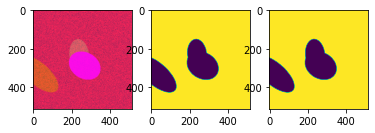

In [68]:
#results of resnet50 backbone
from torch.utils.data import DataLoader
valset = Ellipses([512,512,3], 10000)

num_classes = 2
img, targ = valset[0]
img = img.unsqueeze(0)
targ = targ.unsqueeze(0)
img, targ = img.cuda(), targ.cuda()

net = BiSeNet(2)
net = net.cuda()
net.load_state_dict(torch.load('./checkpoint/best_model_resnet50.pth'))
net.eval()
pred = net(img)
pred = torch.argmax(pred, dim=1)
fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.imshow(img.squeeze().permute(1,2,0).cpu().detach().numpy())
ax1.imshow(pred.squeeze().cpu().detach().numpy())
ax2.imshow(targ.squeeze().cpu().detach().numpy())

In [69]:
# resnet50 version
fin = val(2, net, val_loader)

start val!
mIoU for validation: 0.999


![title](resnet50.png)

# DenseNet121 version

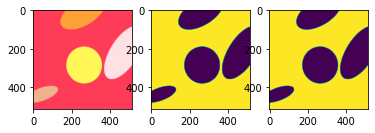

In [78]:
#results of densenet121 backbone
from torch.utils.data import DataLoader
valset = Ellipses([512,512,3], 10000)

num_classes = 2
img, targ = valset[0]
img = img.unsqueeze(0)
targ = targ.unsqueeze(0)
img, targ = img.cuda(), targ.cuda()

net = BiSeNet(2, context_path='densenet121')
net = net.cuda()
net.load_state_dict(torch.load('./checkpoint/best_model_densenet121.pth'))
net.eval()
pred = net(img)
pred = torch.argmax(pred, dim=1)
fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.imshow(img.squeeze().permute(1,2,0).cpu().detach().numpy())
ax1.imshow(pred.squeeze().cpu().detach().numpy())
ax2.imshow(targ.squeeze().cpu().detach().numpy())

In [79]:
# resnet50 version
fin = val(2, net, val_loader)

start val!
mIoU for validation: 0.999


![title](densenet121.png)

**Проиллюстрируйте процесс обучения** сети скриншотами из `tensorboard` (см. `lanpa/tensorboardX`).

Необходимо в частности отобразить кривую обучения и примеры эволюции качества выдаваемых масок.